In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# for visualization on GitHub, comment to use interactively
import plotly.io as pio
pio.renderers.default = 'png'

In [3]:
import tensorflow as tf
import numpy as np
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as colors
import plotly.graph_objects as go
from pprint import pprint
from absl import flags
import config_flags

# Loading data

In [4]:
# RES_DIR = "results/hyperparameters_search/"
RES_DIR = "results/hyperparameters_search_tinyImagenet/"

In [5]:
def list_final_dirs(directory):
    results_paths = []
    for root, dirs, files in os.walk(directory):
        for f in files:
            if "flags.txt" in f:
                results_paths.append(os.path.join(root, f))
    return results_paths

In [6]:
flagfiles = list_final_dirs(RES_DIR)
print("\n".join(flagfiles[:5]))
print(len(flagfiles))

results/hyperparameters_search_tinyImagenet/lr_0.4/nbf_20/am_5/dr_0.6/run_3_flags.txt
results/hyperparameters_search_tinyImagenet/lr_0.4/nbf_20/am_5/dr_0.6/run_2_flags.txt
results/hyperparameters_search_tinyImagenet/lr_0.4/nbf_20/am_5/dr_0.6/run_1_flags.txt
results/hyperparameters_search_tinyImagenet/lr_0.4/nbf_20/am_5/dr_0.6/run_4_flags.txt
results/hyperparameters_search_tinyImagenet/lr_0.4/nbf_20/am_5/dr_0.6/run_0_flags.txt
405


In [7]:
def extract_results(flagfile):
    config_flags.load_flags(flagfile)
    run_flags = flags.FLAGS
    
    history_path = os.path.join(
        run_flags.save_path, 
        run_flags.prefix) + "history.pkl"
    
    try :
        with open(history_path, 'rb') as f:
            history = pickle.load(f)
    except:
        print(f"Run {flagfile} has no history.pkl, potentially crashed.")
        return None
        
    return history
    
    # mocking function
    # return {
    #     "hypersphere_percentage": np.random.uniform(0, 1),
    #     "val_accuracy": np.random.uniform(0, 1),
    #     "val_loss": np.random.uniform(0, 1),
    #     "val_max_val_auroc": np.random.uniform(0, 1),
    #     "val_real_auroc": np.random.uniform(0, 1),
    #     "std_cls_0": np.random.normal(0, 1),
    #     "std_cls_1": np.random.normal(0, 1),
    #     "mean_weights_corr": np.random.uniform(0, 0.2),
    #     "mean_weights_std": np.random.uniform(0, 0.2),
    # }


## Group runs with same parameters

In [8]:
repetition_dict = {}
for file in flagfiles:
    config = file.rsplit('/', 1)[0].replace(RES_DIR, '')
    
    results = extract_results(file)
    if results is None:
        continue
    
    if config not in repetition_dict:
        repetition_dict[config] = {}
        for k in results:
            repetition_dict[config][k] = []
            
    for k, v in results.items():
        repetition_dict[config][k].append(v)


In [9]:
repetition_dict.keys()

dict_keys(['lr_0.4/nbf_20/am_5/dr_0.6', 'lr_0.4/nbf_20/am_5/dr_0.5', 'lr_0.4/nbf_20/am_5/dr_0.4', 'lr_0.4/nbf_20/am_2/dr_0.6', 'lr_0.4/nbf_20/am_2/dr_0.5', 'lr_0.4/nbf_20/am_2/dr_0.4', 'lr_0.4/nbf_20/am_10/dr_0.6', 'lr_0.4/nbf_20/am_10/dr_0.5', 'lr_0.4/nbf_20/am_10/dr_0.4', 'lr_0.4/nbf_5/am_5/dr_0.6', 'lr_0.4/nbf_5/am_5/dr_0.5', 'lr_0.4/nbf_5/am_5/dr_0.4', 'lr_0.4/nbf_5/am_2/dr_0.6', 'lr_0.4/nbf_5/am_2/dr_0.5', 'lr_0.4/nbf_5/am_2/dr_0.4', 'lr_0.4/nbf_5/am_10/dr_0.6', 'lr_0.4/nbf_5/am_10/dr_0.5', 'lr_0.4/nbf_5/am_10/dr_0.4', 'lr_0.4/nbf_10/am_5/dr_0.6', 'lr_0.4/nbf_10/am_5/dr_0.5', 'lr_0.4/nbf_10/am_5/dr_0.4', 'lr_0.4/nbf_10/am_2/dr_0.6', 'lr_0.4/nbf_10/am_2/dr_0.5', 'lr_0.4/nbf_10/am_2/dr_0.4', 'lr_0.4/nbf_10/am_10/dr_0.6', 'lr_0.4/nbf_10/am_10/dr_0.5', 'lr_0.4/nbf_10/am_10/dr_0.4', 'lr_0.5/nbf_20/am_5/dr_0.6', 'lr_0.5/nbf_20/am_5/dr_0.5', 'lr_0.5/nbf_20/am_5/dr_0.4', 'lr_0.5/nbf_20/am_2/dr_0.6', 'lr_0.5/nbf_20/am_2/dr_0.5', 'lr_0.5/nbf_20/am_2/dr_0.4', 'lr_0.5/nbf_20/am_10/dr_0.6', 'l

## Compute mean and std for each parameter set

In [10]:
results_dict = {}
for config, results in repetition_dict.items():
    results_dict[config] = {}
    # for k, v in results.items():
    #     results_dict[config][k] = {
    #         "mean": np.mean(v),
    #         "std": np.std(v),
    #     }
    for k, v in results.items():
        results_dict[config][(k, "mean")] = np.mean(v, axis=0)[-1]
        results_dict[config][(k, "std")] = np.std(v, axis=0)[-1]
        
        if k == "mean_weights_std":
            results_dict[config][(k, "mean")] = np.mean(v)
            results_dict[config][(k, "std")] = np.std(v)

In [11]:
# split config in multiple columns
final_dict = {}
index_2_params = {}
columns = ["Learning rate", "Nb features", "Anchor multiplier", "Distance ratio"]

# "lr": [(0.2, "lr_0.2"), (0.1, "lr_0.1"), (0.01, "lr_0.01")],
# "nb_features": [(5, "nbf_5"), (10, "nbf_10"), (20, "nbf_20")],
# "anchor_multiplier": [(2, "am_2"), (5, "am_5"), (10, "am_10")],
# "distance_ratio": [(0.2, "dr_0.2"), (0.3, "dr_0.3"), (0.4, "dr_0.4")],

final_dict[("idx", "")] = []
for i in columns:
    final_dict[(i, '')] = []

for idx, (config, results) in enumerate(results_dict.items()):
    index_2_params[idx] = config
    params = config.strip().split('/')
    converted_params = []
    converted_params.append(params[0].split('_')[1])
    converted_params.append(params[1].split('_')[1])
    converted_params.append(params[2].split('_')[1])
    converted_params.append(params[3].split('_')[1])
    
    final_dict[("idx", "")].append(idx)
    
    for i, p in enumerate(converted_params):
        final_dict[(columns[i], '')].append(p)
    
    for k, v in results.items():
        final_dict.setdefault(k, []).append(v)
    

# Results in DataFrame

In [12]:
# sort dataframe by val_accuracy
df = pd.DataFrame(final_dict).set_index("idx")
df = df.sort_values(by=[("val_accuracy", "mean")], ascending=False)
df.head()

Learning rate Nb features Anchor multiplier Distance ratio  accuracy  \
                                                                    mean   
idx                                                                        
10            0.4           5                 5            0.5  0.888956   
69            0.3           5                10            0.6  0.879600   
45            0.5          10                 5            0.6  0.880711   
13            0.4           5                 2            0.5  0.886711   
33            0.5          20                10            0.6  0.874711   

              val_accuracy           test_accuracy            ... test_loss  \
          std         mean       std          mean       std  ...      mean   
idx                                                           ...             
10   0.002276       0.7978  0.010342        0.7640  0.008270  ...  1.440436   
69   0.003152       0.7974  0.009604        0.7668  0.008109  ...  1.939884   
45   0.001902       0.7960  0.002280        0.7724  0.009972  ...  1.361152   
13   0.000851       0.7948  0.008158        0.7658  0.004308  ...  0.571452   
33   0.001145       0.7946  0.008616        0.7656  0.006151  ...  3.845985   

              test_real_auroc           test_max_val_auroc            \
          std            mean       std               mean       std   
idx                                                                    
10   0.048658        72.43245  0.791322           75.28044  0.690661   
69   0.050958        74.50083  0.527377           76.49948  0.476145   
45   0.026808        74.10763  0.491380           75.93754  0.586707   
13   0.008224        72.82275  0.774469           74.96420  0.554809   
33   0.058481        74.20243  0.410638           76.03096  0.552200   

    test_oscr           val_hypersphere_percentage            
         mean       std                       mean       std  
idx                                                           
10   61.76759  1.133254                     0.6938  0.002400  
69   63.49143  0.564445                     0.8102  0.005776  
45   63.60549  0.953312                     0.8070  0.004690  
13   62.15051  0.725711                     0.6876  0.007200  
33   63.07133  0.401065                     0.8030  0.010733  

[5 rows x 38 columns]

In [13]:
# sort dataframe by hypersphere_percentage
df = pd.DataFrame(final_dict).set_index("idx")
df = df.round(5)
df = df.sort_values(by=[("val_hypersphere_percentage", "mean")], ascending=False)
df.head()

Learning rate Nb features Anchor multiplier Distance ratio accuracy  \
                                                                   mean   
idx                                                                       
69            0.3           5                10            0.6  0.87960   
51            0.5          10                10            0.6  0.87727   
45            0.5          10                 5            0.6  0.88071   
57            0.3          20                 2            0.6  0.87747   
42            0.5           5                10            0.6  0.88233   

             val_accuracy          test_accuracy           ... test_loss  \
         std         mean      std          mean      std  ...      mean   
idx                                                        ...             
69   0.00315       0.7974  0.00960        0.7668  0.00811  ...   1.93988   
51   0.00250       0.7908  0.00808        0.7624  0.00595  ...   2.76912   
45   0.00190       0.7960  0.00228        0.7724  0.00997  ...   1.36115   
57   0.00138       0.7924  0.00656        0.7666  0.00393  ...   0.77536   
42   0.00222       0.7946  0.00472        0.7718  0.00828  ...   1.98202   

             test_real_auroc          test_max_val_auroc          test_oscr  \
         std            mean      std               mean      std      mean   
idx                                                                           
69   0.05096        74.50083  0.52738           76.49948  0.47615  63.49143   
51   0.07014        74.16268  0.55985           76.05168  0.91063  63.02569   
45   0.02681        74.10763  0.49138           75.93754  0.58671  63.60549   
57   0.01014        74.06992  0.39864           76.23958  0.25294  63.24543   
42   0.03387        74.50896  0.30860           76.34472  0.48513  63.43681   

             val_hypersphere_percentage           
         std                       mean      std  
idx                                               
69   0.56445                     0.8102  0.00578  
51   0.81335                     0.8096  0.01234  
45   0.95331                     0.8070  0.00469  
57   0.36007                     0.8070  0.00657  
42   0.48267                     0.8066  0.00361  

[5 rows x 38 columns]

# Graphs

## Filtering results

In [14]:
# TODO: we know that we don't want a learning rate of 0.01 so we can remove those
# experiments 
# df = df[(df[("Learning rate", "")] != "0.01") & (df[("Nb features", "")] != "5")]
# df = df[(df[("Learning rate", "")] != "0.01")]
# df = df[np.isin(df[("Learning rate", "")].values, ["0.3", "0.4"]) & np.isin(df[("Distance ratio", "")].values, ["0.5", "0.6"])]
# df = df[np.isin(df[("Learning rate", "")].values, ["0.3"]) & np.isin(df[("Distance ratio", "")].values, ["0.6"])]
# df = df[np.isin(df[("Distance ratio", "")].values, ["0.6"])]


In [15]:
def scatter_results(df, x, y, x_label, y_label, title, labels_column, legend_title=None):

    fig = go.Figure()
    
    for label in df[labels_column].unique():
        class_df=df[df[labels_column] == label]
        
        # Add hover text
        hover_text = [
            f"Learning rate: {lr}<br>Nb features: {nbf}<br>Anchor multiplier: {am}<br>Distance ratio: {dr}"
            for lr, nbf, am, dr in zip(
                class_df[("Learning rate", "")],
                class_df[("Nb features", "")],
                class_df[("Anchor multiplier", "")],
                class_df[("Distance ratio", "")],
            )
        ]
        
        fig.add_trace(
            go.Scatter(
                x=class_df[x],
                y=class_df[y],
                mode='markers',
                marker=dict(
                    size=10,
                ),
                name=str(label),
                text=hover_text,
                hoverinfo="text"
            )
        )
    
    # Change legend title
    fig.update_layout(
        legend_title=legend_title,
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
    )
    
    fig.show()

## Hypersphere percentage vs Accuracy

In [16]:
np.corrcoef(
    df[('val_hypersphere_percentage', 'mean')],
    df[('val_accuracy', 'mean')]
)

array([[1.        , 0.39245402],
       [0.39245402, 1.        ]])

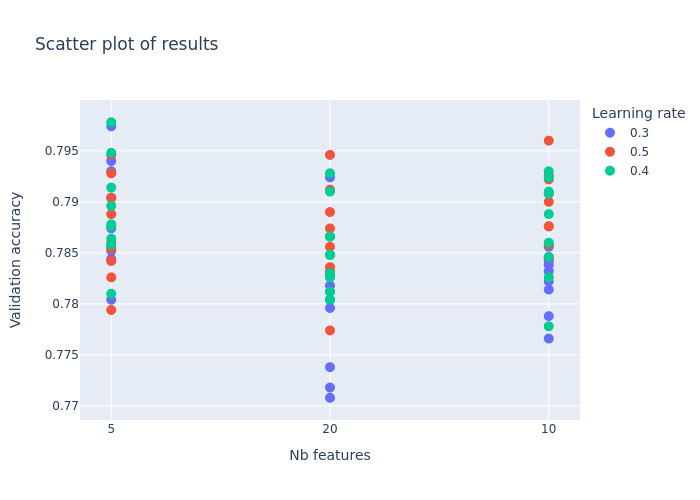

In [17]:
scatter_results(
    df,
    x = ('Nb features', ''),
    y = ('val_accuracy', 'mean'),
    x_label = "Nb features",
    y_label = "Validation accuracy",
    title = "Scatter plot of results",
    labels_column = ("Learning rate", ""),
    legend_title = "Learning rate"
)

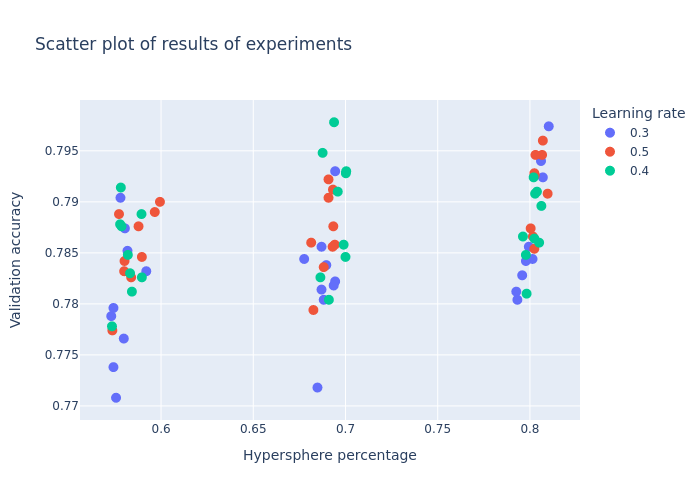

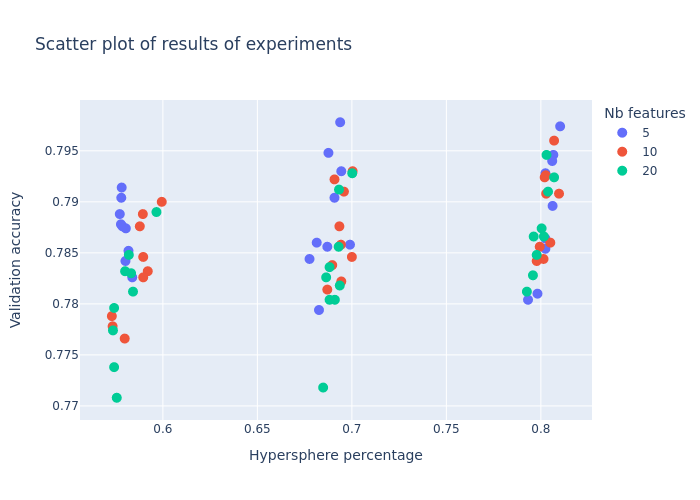

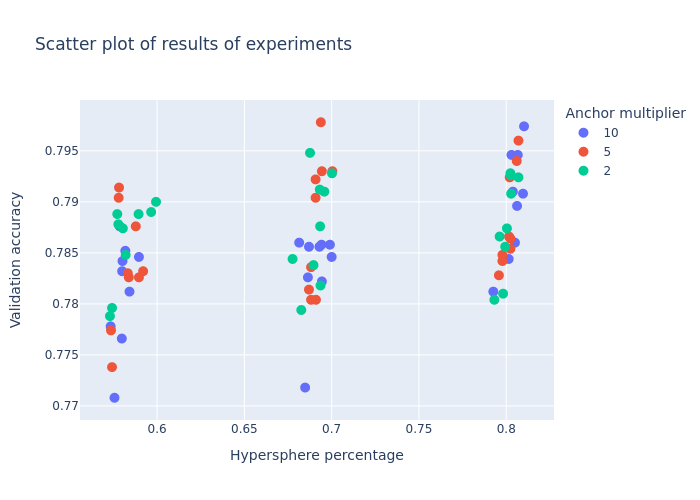

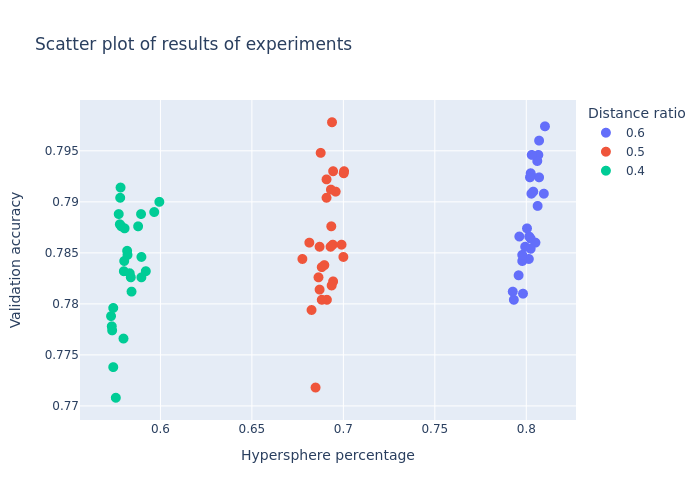

In [18]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_hypersphere_percentage', 'mean'),
        y=('val_accuracy', 'mean'),
        x_label='Hypersphere percentage',
        y_label='Validation accuracy',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Hypersphere percentage vs Real AUROC

In [19]:
np.corrcoef(
    df[('val_hypersphere_percentage', 'mean')],
    df[('val_real_auroc', 'mean')],
)

array([[1.        , 0.90208938],
       [0.90208938, 1.        ]])

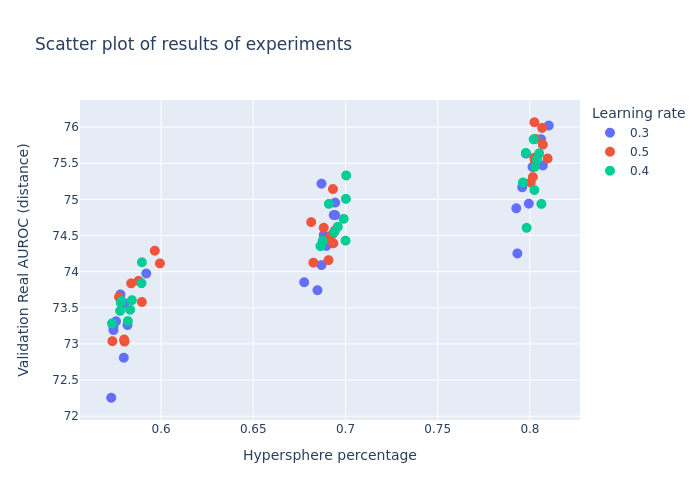

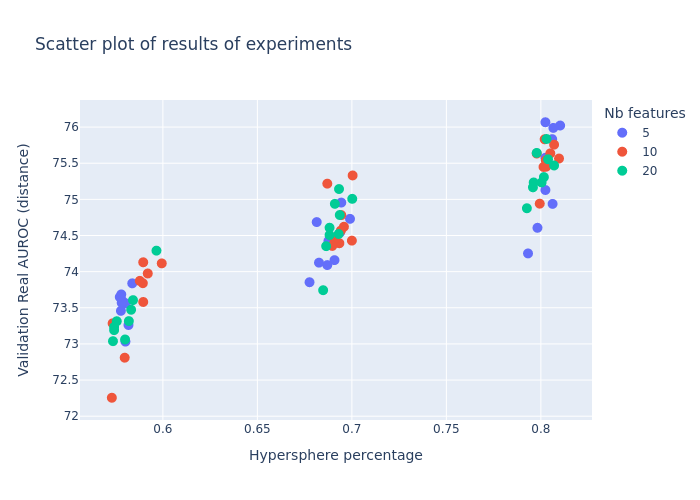

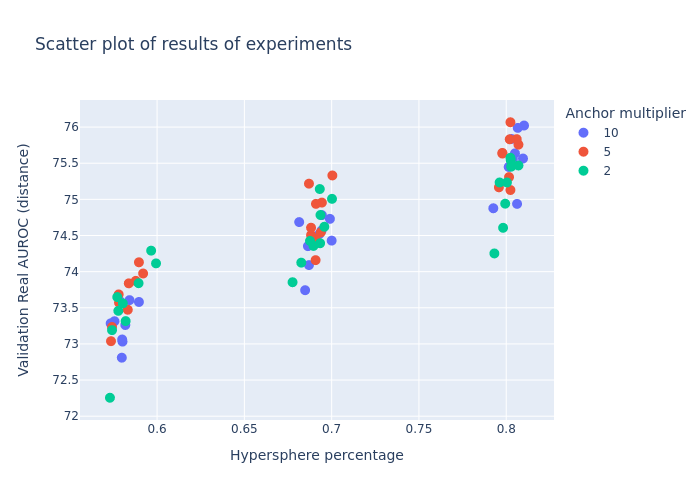

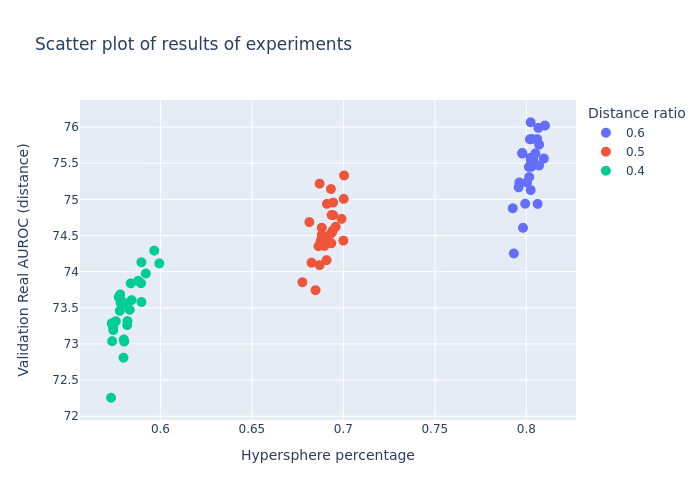

In [20]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_hypersphere_percentage', 'mean'),
        y=('val_real_auroc', 'mean'),
        x_label='Hypersphere percentage',
        y_label='Validation Real AUROC (distance)',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Accuracy vs hypersphere percentage

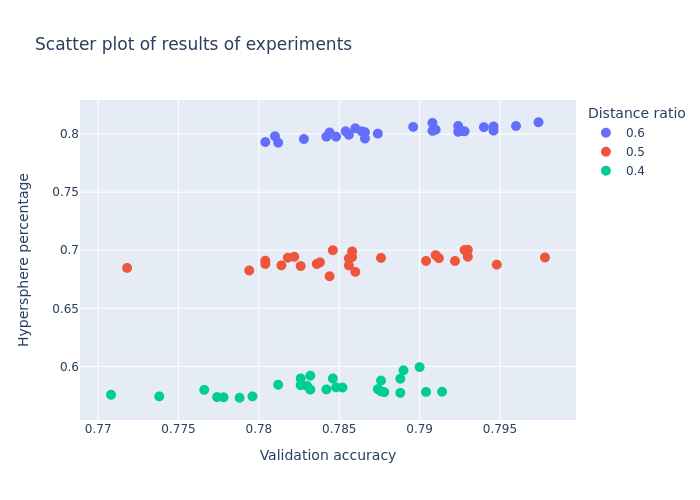

In [21]:
scatter_results(
    df,
    x=('val_accuracy', 'mean'),
    y=('val_hypersphere_percentage', 'mean'),
    x_label='Validation accuracy',
    y_label='Hypersphere percentage',
    title='Scatter plot of results of experiments',
    labels_column=('Distance ratio', ''),
    legend_title='Distance ratio'
)

## Accuracy vs Real AUROC

In [22]:
np.corrcoef(
    df[('val_accuracy', 'mean')],
    df[('val_real_auroc', 'mean')],
)

array([[1.        , 0.54879983],
       [0.54879983, 1.        ]])

In [23]:
np.corrcoef(
    df[('val_accuracy', 'mean')],
    df[('val_max_val_auroc', 'mean')],
)

array([[1.        , 0.54987034],
       [0.54987034, 1.        ]])

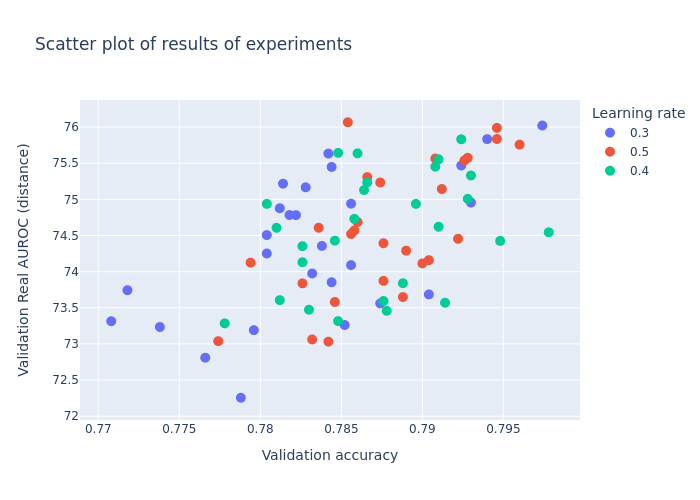

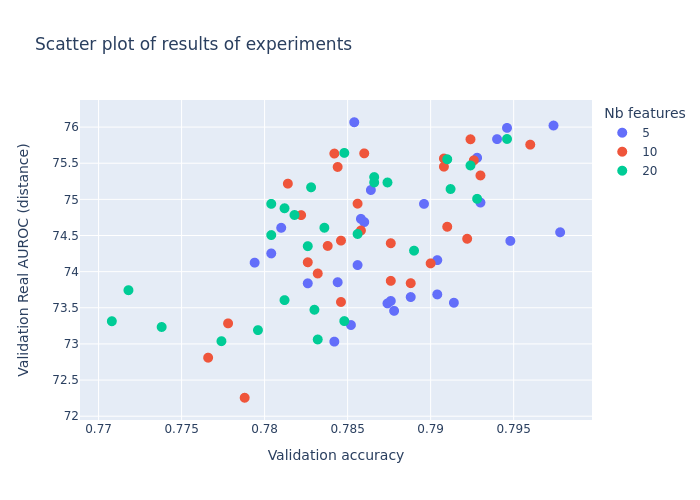

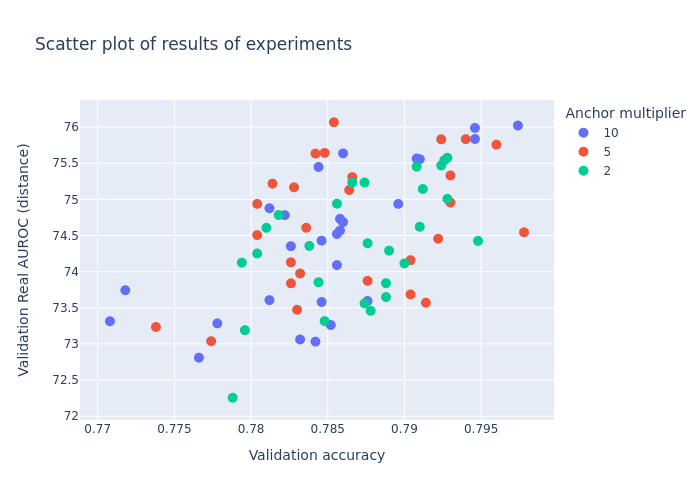

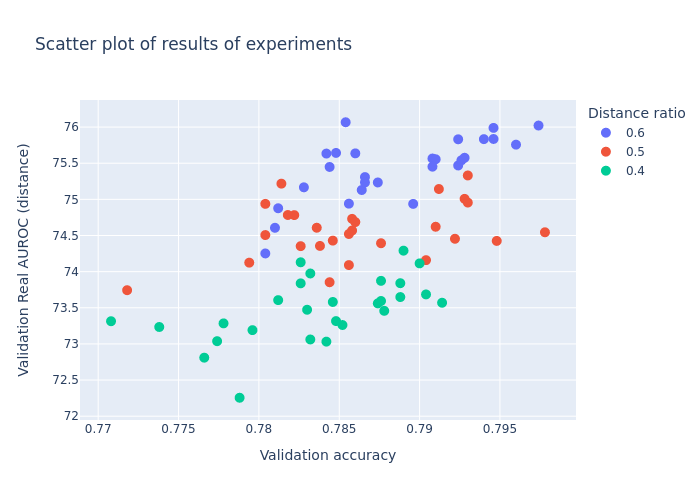

In [24]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_accuracy', 'mean'),
        y=('val_real_auroc', 'mean'),
        x_label='Validation accuracy',
        y_label='Validation Real AUROC (distance)',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Accuracy vs weights correlation

In [25]:
np.corrcoef(
    df[('val_accuracy', 'mean')],
    df[('mean_weights_corr', 'mean')],
)

array([[ 1.        , -0.37842459],
       [-0.37842459,  1.        ]])

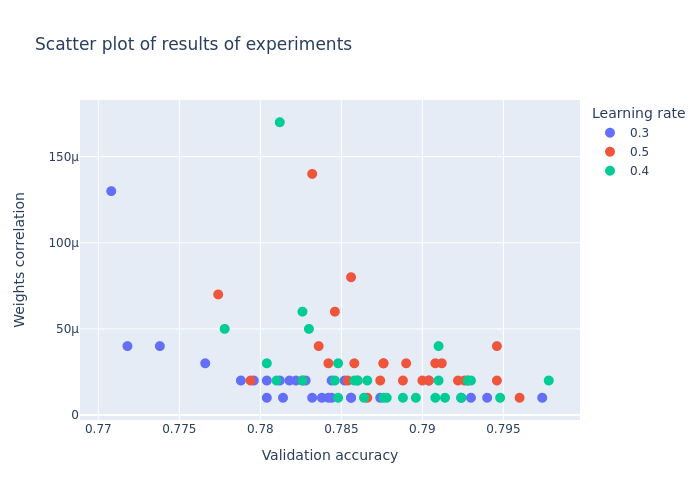

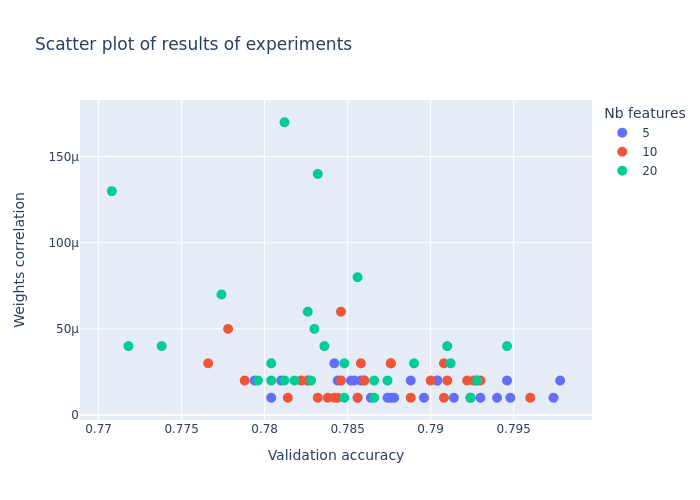

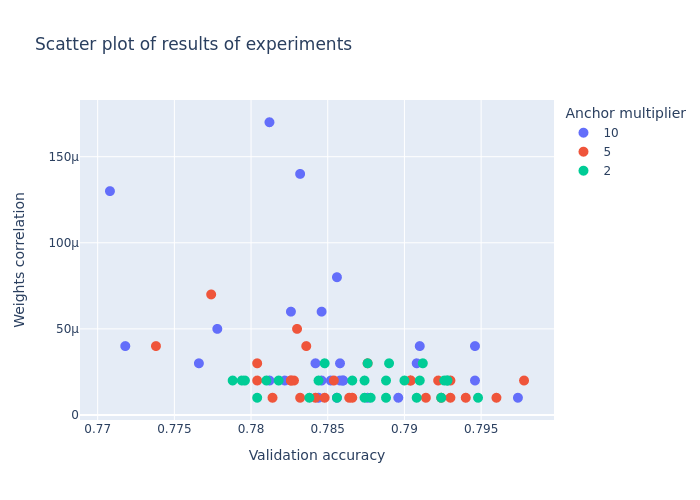

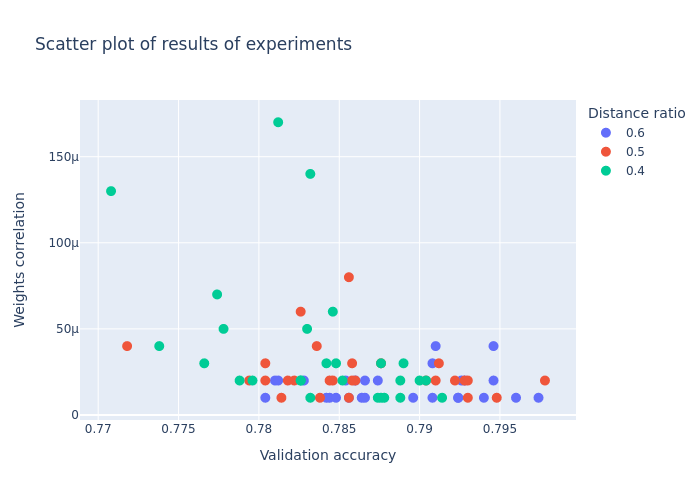

In [26]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_accuracy', 'mean'),
        y=('mean_weights_corr', 'mean'),
        x_label='Validation accuracy',
        y_label='Weights correlation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Accuracy vs weights std

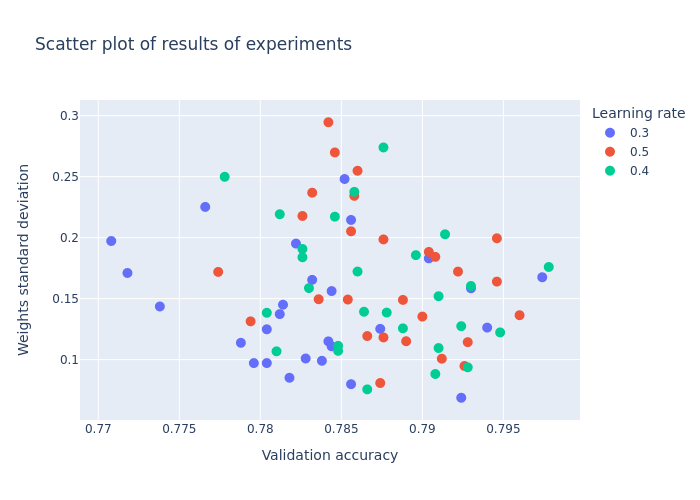

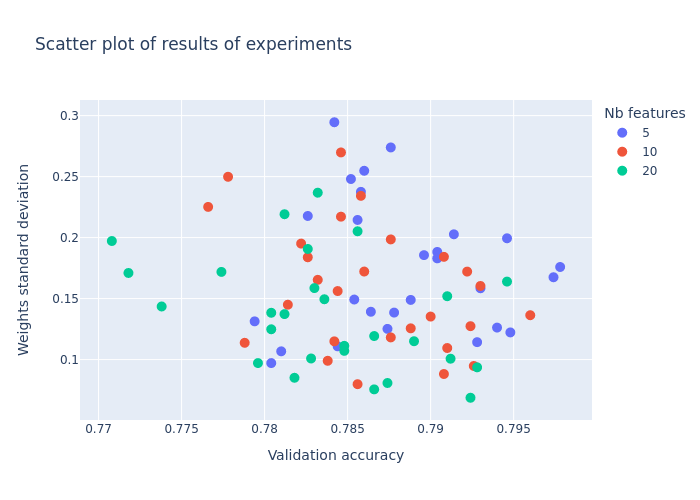

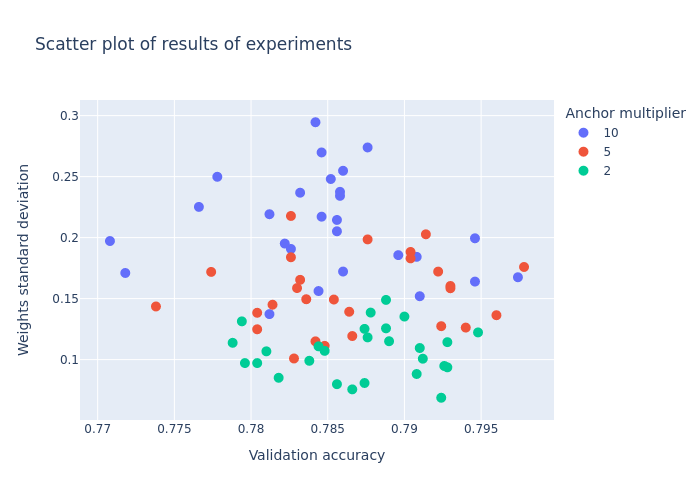

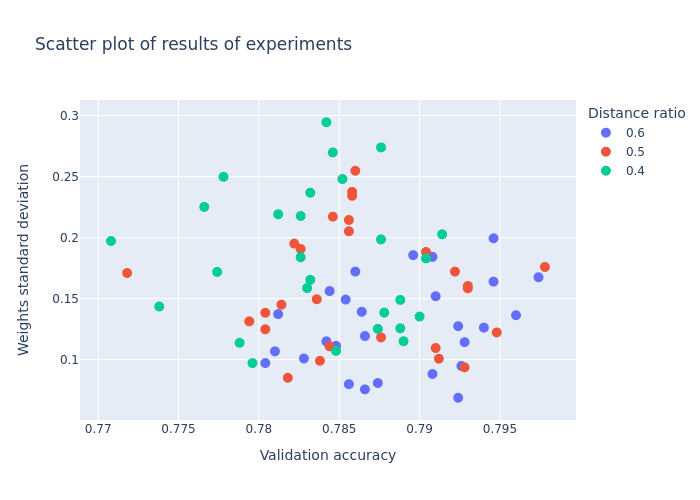

In [27]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_accuracy', 'mean'),
        y=('mean_weights_std', 'mean'),
        x_label='Validation accuracy',
        y_label='Weights standard deviation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Real AUROC vs weights std

In [28]:
# df_no_std = df[df[("Std penalty", "")] == "No std"]
# plot_pareto_front(
#     df_no_std,
#     x=('val_real_auroc', 'mean'),
#     y=('mean_weights_std', 'mean'),
#     x_label='Validation Real AUROC (distance)',
#     y_label='Weights standard deviation',
#     title='Scatter plot of results of experiments without std penalty',
#     labels_column=("Learning rate", ""),
#     legend_title="Learning rate"
# )

In [29]:
for val in df[("Learning rate", "")].unique():
    print("Learning rate:", val)
    
    df_no_std = df[df[("Learning rate", "")] == val]

    a = np.corrcoef(
        df_no_std[('val_accuracy', 'mean')],
        df_no_std[('mean_weights_std', 'mean')],
    )
    print("\tCorrelation between val_accuracy and mean_weights_std", a[0, 1])

    b = np.corrcoef(
        df_no_std[('val_real_auroc', 'mean')],
        df_no_std[('mean_weights_std', 'mean')],
    )
    print("\tCorrelation between val_real_auroc and mean_weights_std", b[0, 1])

Learning rate: 0.3
	Correlation between val_accuracy and mean_weights_std -0.12993057847764675
	Correlation between val_real_auroc and mean_weights_std -0.3137806745273317
Learning rate: 0.5
	Correlation between val_accuracy and mean_weights_std -0.3273036693983524
	Correlation between val_real_auroc and mean_weights_std -0.4910837652573733
Learning rate: 0.4
	Correlation between val_accuracy and mean_weights_std -0.2785892027294363
	Correlation between val_real_auroc and mean_weights_std -0.4322896722650106


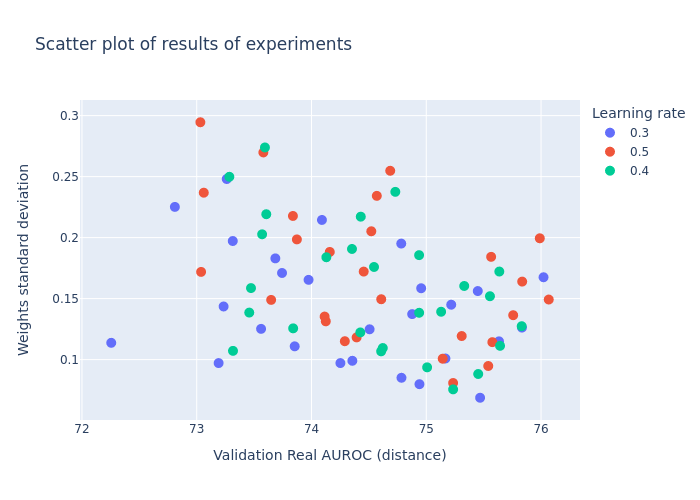

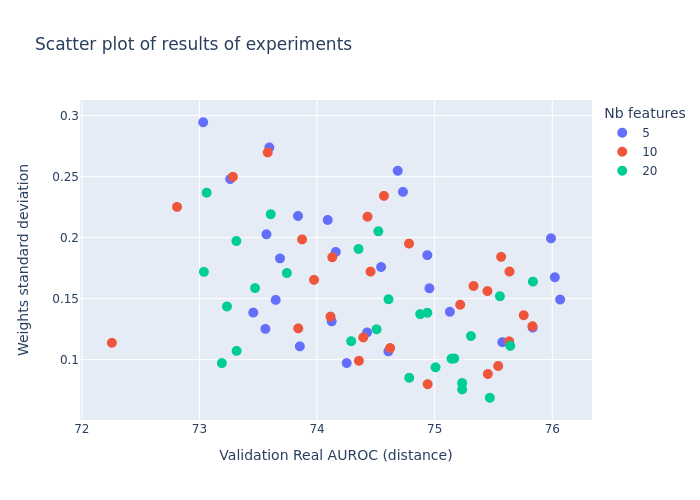

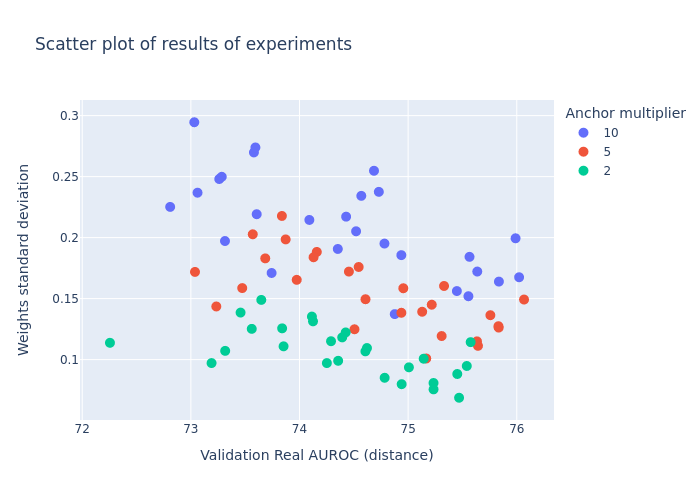

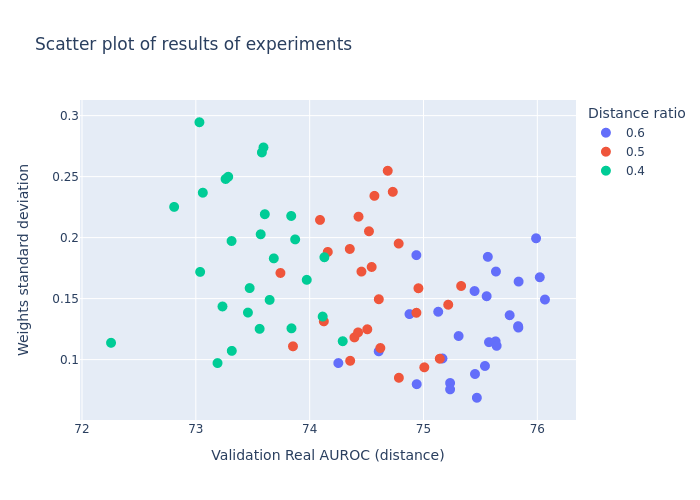

In [30]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_real_auroc', 'mean'),
        y=('mean_weights_std', 'mean'),
        x_label='Validation Real AUROC (distance)',
        y_label='Weights standard deviation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Real AUROC vs weights correlation

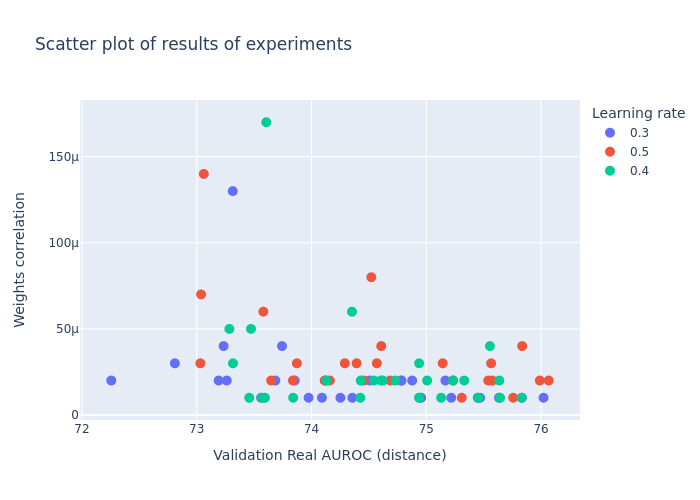

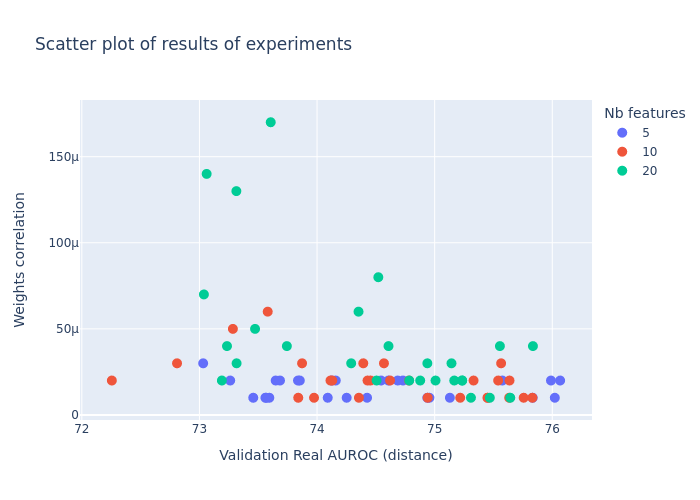

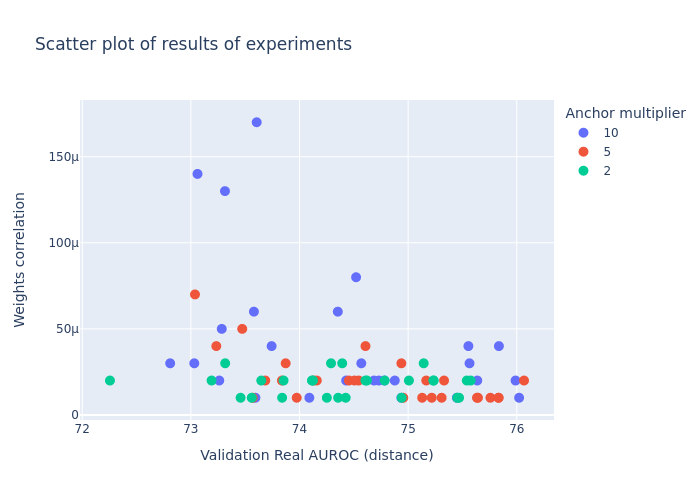

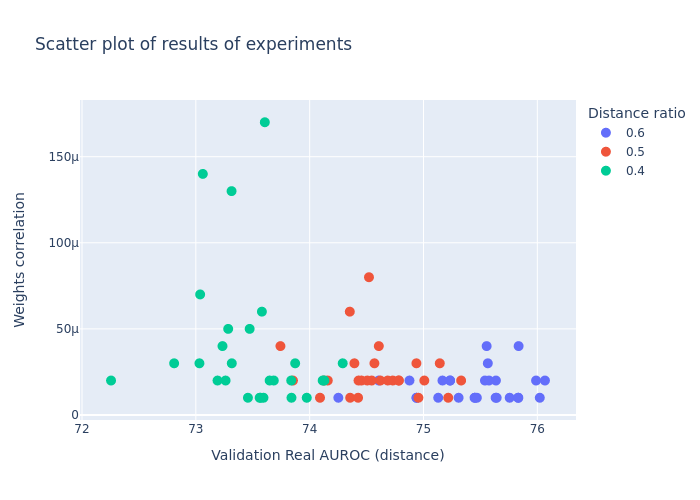

In [31]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_real_auroc', 'mean'),
        y=('mean_weights_corr', 'mean'),
        x_label='Validation Real AUROC (distance)',
        y_label='Weights correlation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

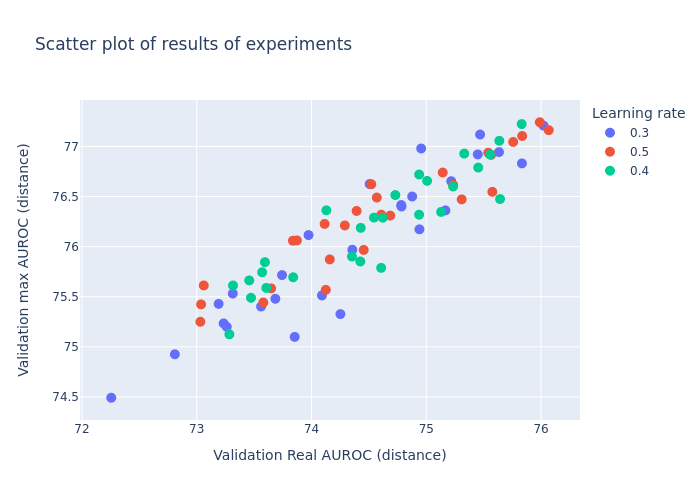

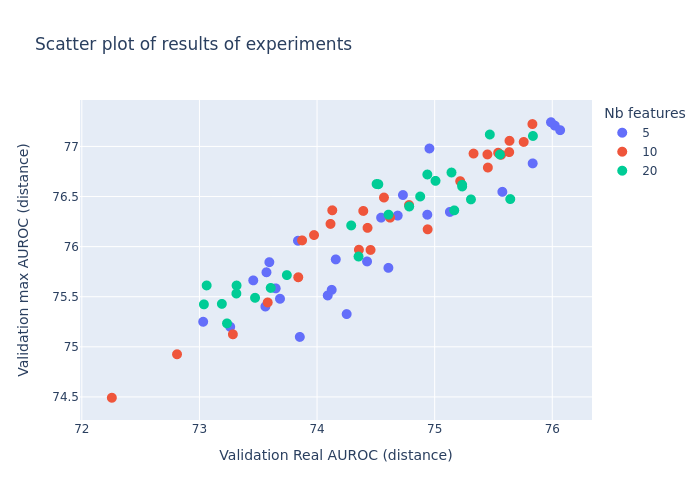

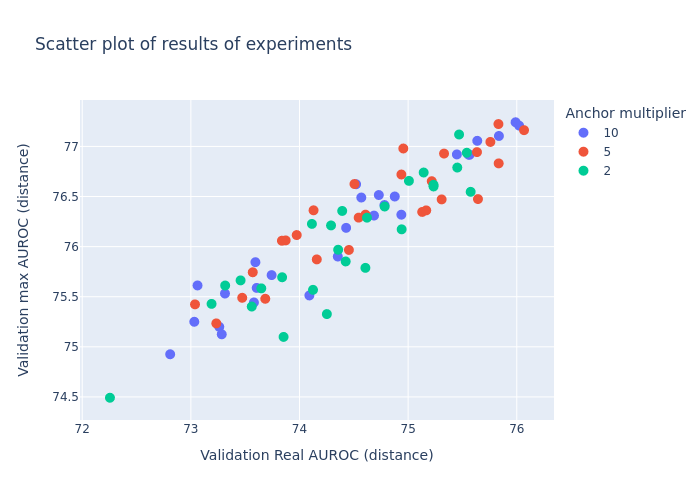

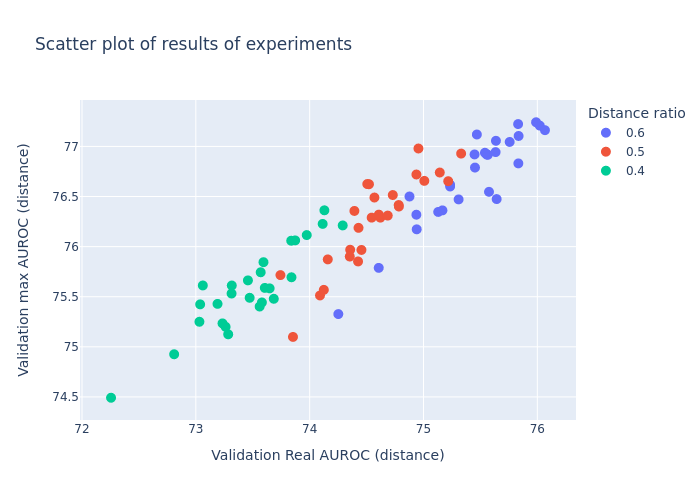

In [32]:
for labels_columns in df.columns[:4]:
    scatter_results(
        df,
        x=('val_real_auroc', 'mean'),
        y=('val_max_val_auroc', 'mean'),
        x_label='Validation Real AUROC (distance)',
        y_label='Validation max AUROC (distance)',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

# Additional plots

In [33]:
# make violin plot of val_accuracy for each hyperparameter
def plot_violin(df, x, y, x_label, y_label, title, labels_column, legend_title=None):
    fig = go.Figure()
    
    for label in df[labels_column].unique():
        class_df=df[df[labels_column] == label].sort_values(by=[x], )
        
        fig.add_trace(
            go.Violin(
                x=class_df[x],
                y=class_df[y],
                name=str(label),
                box_visible=False,
                meanline_visible=True,
            )
        )
    
    # Change legend title
    fig.update_layout(
        legend_title=legend_title,
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
    )
    
    fig.show()

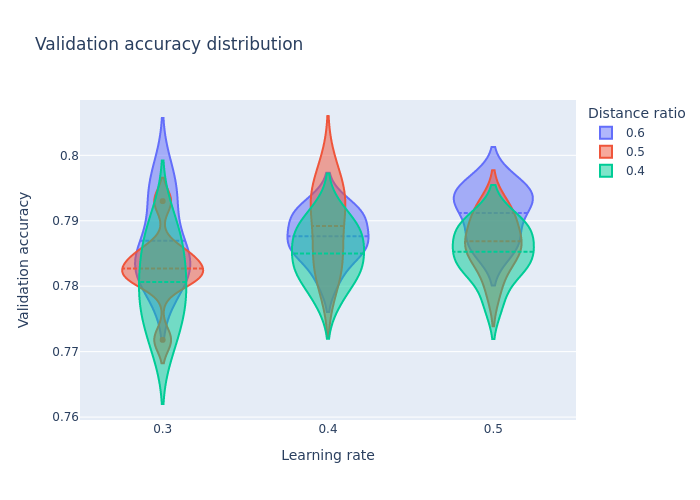

In [34]:
plot_violin(
    df,
    x=("Learning rate", ""),
    y=("val_accuracy", "mean"),
    x_label="Learning rate",
    y_label="Validation accuracy",
    title="Validation accuracy distribution",
    labels_column=("Distance ratio", ""),
    legend_title="Distance ratio"
)

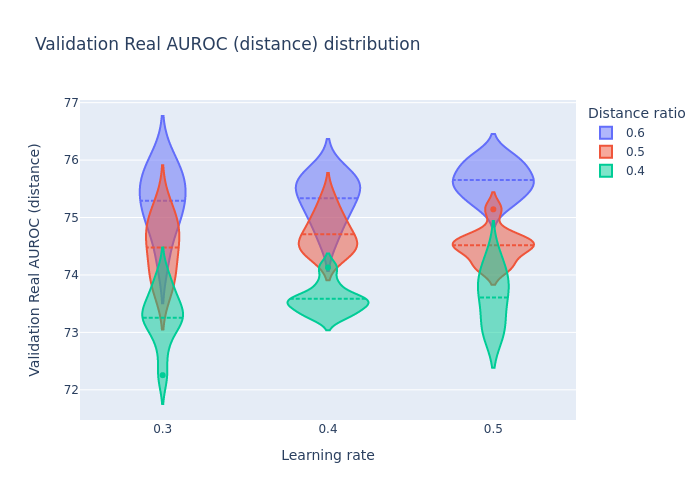

In [35]:
plot_violin(
    df,
    x=("Learning rate", ""),
    y=("val_real_auroc", "mean"),
    x_label="Learning rate",
    y_label="Validation Real AUROC (distance)",
    title="Validation Real AUROC (distance) distribution",
    labels_column=("Distance ratio", ""),
    legend_title="Distance ratio"
)

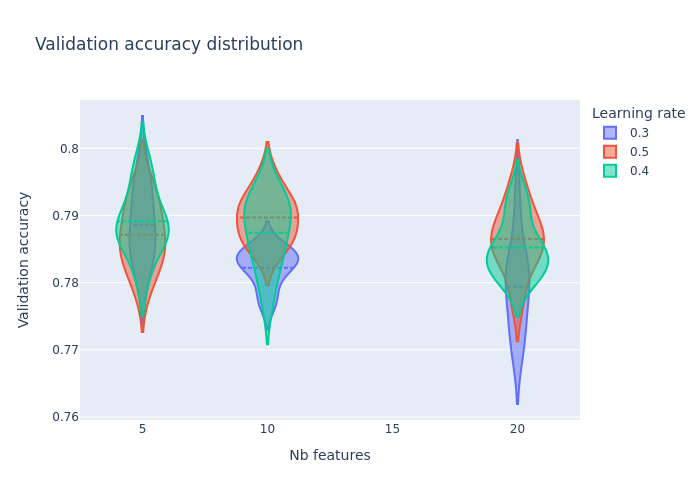

In [36]:
conv_df = df.copy()
conv_df[("Nb features", "")] = conv_df[("Nb features", "")].astype(int)

plot_violin(
    conv_df,
    x=("Nb features", ""),
    y=("val_accuracy", "mean"),
    x_label="Nb features",
    y_label="Validation accuracy",
    title="Validation accuracy distribution",
    labels_column=("Learning rate", ""),
    legend_title="Learning rate"
)

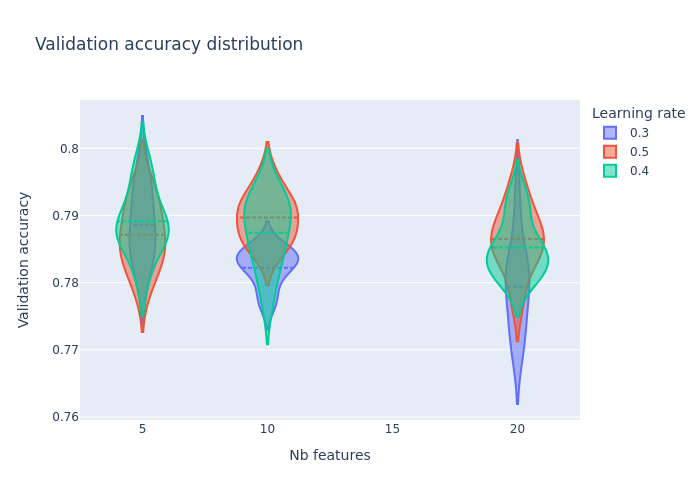

In [37]:
conv_df = df.copy()
conv_df[("Nb features", "")] = conv_df[("Nb features", "")].astype(int)

plot_violin(
    conv_df,
    x=("Nb features", ""),
    y=("val_accuracy", "mean"),
    x_label="Nb features",
    y_label="Validation accuracy",
    title="Validation accuracy distribution",
    labels_column=("Learning rate", ""),
    legend_title="Learning rate"
)